# 챗봇을 만들어보자  
----  
####부제 : 친구가 필요해  
  
####목차  
 - 베이스 라인
 - 에폭 200
 - 파라미터 변경

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_file_path = '/content/drive/MyDrive/colab/Word/ChatbotData.csv'
dataset_file_path

'/content/drive/MyDrive/colab/Word/ChatbotData.csv'

In [ ]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

# 멀티 헤드 어텐션 함수
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

In [ ]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [ ]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [ ]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [ ]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [ ]:
# 사용할 샘플의 최대 개수
MAX_SAMPLES = 30000
print(MAX_SAMPLES)

30000


In [ ]:
# 전처리 함수
def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
#   sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
  sentence = sentence.strip()
  return sentence

In [ ]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
def load_conversations():
    inputs, outputs = [], []
    with open(dataset_file_path, 'r') as file:
        lines = file.readlines()
        
    conversation = []
    for line in lines[1:]:
        parts = line.split(',')
        conversation.append([line for line in parts[0:2]])

        
    for i in range(len(conversation) - 1):
        # 전처리 함수를 질문에 해당되는 inputs와 답변에 해당되는 outputs에 적용.
        inputs.append(preprocess_sentence(conversation[i][0]))
        outputs.append(preprocess_sentence(conversation[i][1]))

    if len(inputs) >= MAX_SAMPLES:
        return inputs, outputs

    return inputs, outputs

In [ ]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
questions, answers = load_conversations()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11822
전체 샘플 수 : 11822


In [ ]:
questions[13], answers[22]

('가끔은 혼자인게 좋다', '가장 확실한 시간은 오늘이에요 . 어제와 내일을 놓고 고민하느라 시간을 낭비하지 마세요 .')

In [ ]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성. (Tensorflow 2.3.0 이상) (클라우드는 2.4 입니다)
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [ ]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [ ]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8149]
END_TOKEN의 번호 : [8150]


In [ ]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8151


In [ ]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[22])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[22])))

정수 인코딩 후의 21번째 질문 샘플: [387, 809, 43, 410, 2]
정수 인코딩 후의 21번째 답변 샘플: [387, 809, 912, 6515, 12, 5068, 7579, 1107, 7764, 355, 5575, 44, 1]


In [ ]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [ ]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

In [ ]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8151
필터링 후의 질문 샘플 개수: 11822
필터링 후의 답변 샘플 개수: 11822


In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [ ]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    3140864     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

In [ ]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

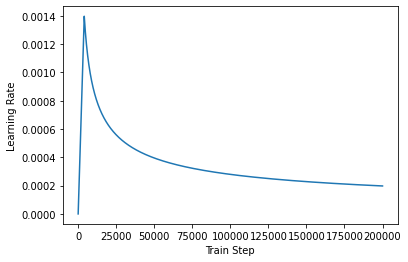

In [ ]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
185/185 [==============================] - 19s 55ms/step - loss: 1.4384 - accuracy: 0.0245
Epoch 2/20
185/185 [==============================] - 10s 53ms/step - loss: 1.1713 - accuracy: 0.0487
Epoch 3/20
185/185 [==============================] - 10s 53ms/step - loss: 0.9983 - accuracy: 0.0501
Epoch 4/20
185/185 [==============================] - 10s 54ms/step - loss: 0.9232 - accuracy: 0.0537
Epoch 5/20
185/185 [==============================] - 10s 54ms/step - loss: 0.8668 - accuracy: 0.0572
Epoch 6/20
185/185 [==============================] - 10s 54ms/step - loss: 0.8075 - accuracy: 0.0615
Epoch 7/20
185/185 [==============================] - 10s 55ms/step - loss: 0.7407 - accuracy: 0.0677
Epoch 8/20
185/185 [==============================] - 10s 55ms/step - loss: 0.6676 - accuracy: 0.0753
Epoch 9/20
185/185 [==============================] - 10s 55ms/step - loss: 0.5887 - accuracy: 0.0839
Epoch 10/20
185/185 [==============================] - 10s 56ms/step - loss: 0.506

In [ ]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

In [ ]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

In [ ]:
sentence_generation('집에 가고 싶다')

입력 : 집에 가고 싶다
출력 : 집이 최고죠 .


'집이 최고죠 .'

In [ ]:
sentence_generation('햇볕은 쨍쨍')

입력 : 햇볕은 쨍쨍
출력 : 덜 부담스럽게 연락하는 방법이 있는지 모르겠네요 .


'덜 부담스럽게 연락하는 방법이 있는지 모르겠네요 .'

In [ ]:
sentence_generation('좋은 하루')

입력 : 좋은 하루
출력 : 내일도 좋은 하루 보내세요 .


'내일도 좋은 하루 보내세요 .'

In [ ]:
sentence_generation('여기는 어디')

입력 : 여기는 어디
출력 : 퍼가요~


'퍼가요~'

In [ ]:
sentence_generation('핸드폰')

입력 : 핸드폰
출력 : 기억에서 지울 순 없지만 최대한 생각 말아보셔요 .


'기억에서 지울 순 없지만 최대한 생각 말아보셔요 .'

In [ ]:
sentence_generation('너 봤구나')

입력 : 너 봤구나
출력 : 아직 힘들시기에요 .


'아직 힘들시기에요 .'

In [ ]:
sentence_generation('졸려 죽겠어')

입력 : 졸려 죽겠어
출력 : 오늘 일찍 주무세요 .


'오늘 일찍 주무세요 .'

In [ ]:
sentence_generation('주말이 언제 올까?')

입력 : 주말이 언제 올까?
출력 : 천천히 보내주세요 .


'천천히 보내주세요 .'

In [ ]:
sentence_generation('피곤해')

입력 : 피곤해
출력 : 좀 더 일찍 잠자리에 들어보세요 .


'좀 더 일찍 잠자리에 들어보세요 .'

### 베이스라인 결과  
----  
꽤나 말을 잘하는 녀석이 만들어졌다. 집이 최고라는 걸 아는 이 녀석은 아주 잘 배운녀석이라고 생각하지만, 몇 몇 단어들에 대한 출력물은 대화라고 할 수 없는 수준으로 보인다. 데이터셋을 더 늘리는 방법을 사용한다면 좋겠지만 여기에서는 그런 방법을 사용하기에는 힘드니 epoch를 더 늘려보기로 결정했다.

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
EPOCHS = 200
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/200
185/185 [==============================] - 16s 55ms/step - loss: 0.0252 - accuracy: 0.1684
Epoch 2/200
185/185 [==============================] - 10s 55ms/step - loss: 0.0163 - accuracy: 0.1706
Epoch 3/200
185/185 [==============================] - 10s 56ms/step - loss: 0.0103 - accuracy: 0.1722
Epoch 4/200
185/185 [==============================] - 10s 56ms/step - loss: 0.0071 - accuracy: 0.1729
Epoch 5/200
185/185 [==============================] - 10s 56ms/step - loss: 0.0063 - accuracy: 0.1730
Epoch 6/200
185/185 [==============================] - 10s 56ms/step - loss: 0.0064 - accuracy: 0.1729
Epoch 7/200
185/185 [==============================] - 10s 56ms/step - loss: 0.0066 - accuracy: 0.1729
Epoch 8/200
185/185 [==============================] - 10s 56ms/step - loss: 0.0068 - accuracy: 0.1728
Epoch 9/200
185/185 [==============================] - 10s 56ms/step - loss: 0.0074 - accuracy: 0.1726
Epoch 10/200
185/185 [==============================] - 10s 56ms/step - l

In [ ]:
sentence_generation('집에 가고 싶다')

입력 : 집에 가고 싶다
출력 : 집이 최고죠 .


'집이 최고죠 .'

In [ ]:
sentence_generation('햇볕은 쨍쨍')

입력 : 햇볕은 쨍쨍
출력 : 광합성 추천합니다 .


'광합성 추천합니다 .'

In [ ]:
sentence_generation('좋은 하루')

입력 : 좋은 하루
출력 : 내일도 좋은 하루 보내세요 .


'내일도 좋은 하루 보내세요 .'

In [ ]:
sentence_generation('여기는 어디')

입력 : 여기는 어디
출력 : 소리를 크게한번 질러보세요 .


'소리를 크게한번 질러보세요 .'

In [ ]:
sentence_generation('핸드폰')

입력 : 핸드폰
출력 : 시간을 정해보세요 .


'시간을 정해보세요 .'

In [ ]:
sentence_generation('너 봤구나')

입력 : 너 봤구나
출력 : 여전하던가요 ?


'여전하던가요 ?'

In [ ]:
sentence_generation('졸려 죽겠어')

입력 : 졸려 죽겠어
출력 : 바람이라도 쐬고 오는 건 어떨까요 .


'바람이라도 쐬고 오는 건 어떨까요 .'

In [ ]:
sentence_generation('주말이 언제 올까?')

입력 : 주말이 언제 올까?
출력 : 자신에게 시간을 더 주세요 .


'자신에게 시간을 더 주세요 .'

In [ ]:
sentence_generation('피곤해')

입력 : 피곤해
출력 : 푹 쉬세요 .


'푹 쉬세요 .'

#### 중간 회고  
----  
이번엔 epoch를 200으로 늘려보았더니 확실히 똑똑해진 모습을 보여줬다. 아무래도 언더피팅 상태였나보다. 몇 가지 단어를 더 입력해보면 어땠을까하는 아쉬움이 남지만 이 당시에는 급급했기에 어쩔 수 없었다. 특히 햇볕은 쨍쨍이라는 말에 대한 답이 꽤나 만족스럽다. 광합성을 아는 녀석이라니 잘 배운 녀석이 틀림없다. 그리고 너 봤구나라는 입력에 대한 답변 또한 기존의 모델에서 많이 달라진 모습을 보이고 의미가 연결되는 답변을 내놓았다. 이 두가지가 굉장히 흡족하였다. 하지만 핸드폰이란 입력은 입력자체가 난해해서 그런지 매번 답변을 제대로 해내지 못하는 모습이다. 아무래도 입력단어에 대한 유추가 불가능한 것 같다. 

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
EPOCHS = 400
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/400
185/185 [==============================] - 16s 55ms/step - loss: 5.5595e-04 - accuracy: 0.1738
Epoch 2/400
185/185 [==============================] - 10s 56ms/step - loss: 5.2742e-04 - accuracy: 0.1738
Epoch 3/400
185/185 [==============================] - 10s 56ms/step - loss: 5.2608e-04 - accuracy: 0.1738
Epoch 4/400
185/185 [==============================] - 10s 57ms/step - loss: 5.4736e-04 - accuracy: 0.1737
Epoch 5/400
185/185 [==============================] - 10s 56ms/step - loss: 6.2117e-04 - accuracy: 0.1737
Epoch 6/400
185/185 [==============================] - 10s 56ms/step - loss: 6.6775e-04 - accuracy: 0.1737
Epoch 7/400
185/185 [==============================] - 10s 55ms/step - loss: 7.5063e-04 - accuracy: 0.1737
Epoch 8/400
185/185 [==============================] - 10s 55ms/step - loss: 9.3899e-04 - accuracy: 0.1737
Epoch 9/400
185/185 [==============================] - 10s 56ms/step - loss: 0.0010 - accuracy: 0.1737
Epoch 10/400
185/185 [===================

In [ ]:
sentence_generation('집에 가고 싶다')

입력 : 집에 가고 싶다
출력 : 집이 최고죠 .


'집이 최고죠 .'

In [ ]:
sentence_generation('햇볕은 쨍쨍')

입력 : 햇볕은 쨍쨍
출력 : 광합성 추천합니다 .


'광합성 추천합니다 .'

In [ ]:
sentence_generation('좋은 하루')

입력 : 좋은 하루
출력 : 수십번 생각이 나나 봐요 .


'수십번 생각이 나나 봐요 .'

In [ ]:
sentence_generation('여기는 어디')

입력 : 여기는 어디
출력 : 저는 비밀을 보장해요 . 답답하다면 저에게 말해보세요 .


'저는 비밀을 보장해요 . 답답하다면 저에게 말해보세요 .'

In [ ]:
sentence_generation('핸드폰')

입력 : 핸드폰
출력 : 시간을 정해보세요 .


'시간을 정해보세요 .'

In [ ]:
sentence_generation('너 봤구나')

입력 : 너 봤구나
출력 : 많이 알면 도움이 되겠죠 .


'많이 알면 도움이 되겠죠 .'

In [ ]:
sentence_generation('졸려 죽겠어')

입력 : 졸려 죽겠어
출력 : 한 번 말을 걸어보세요 .


'한 번 말을 걸어보세요 .'

In [ ]:
sentence_generation('주말이 언제 올까?')

입력 : 주말이 언제 올까?
출력 : 중요한 건 노력하는 과정이에요 .


'중요한 건 노력하는 과정이에요 .'

In [ ]:
sentence_generation('피곤해')

입력 : 피곤해
출력 : 푹 쉬세요 .


'푹 쉬세요 .'

#### 중간 회고  
기존의 모델에 400회 epoch를 더하였더니 오히려 출력물의 결과가 기존보다 나빠진 것 같다. 사실 이러한 평가 또한 주관적인 것이라 나빠졌다!라는 확실한 대답은 사람마다 다를 수 있으나, 적어도 내 입장에서는 확실히 기존의 200epoch의 모델이 출력한 결과들이 더 마음에 든다. 그렇기에 이 녀석은 오버피팅이 아닌가 하는 의심을 가지게 되었다.

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
EPOCHS = 300
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/300
185/185 [==============================] - 25s 72ms/step - loss: 1.4806 - accuracy: 0.0176
Epoch 2/300
185/185 [==============================] - 13s 72ms/step - loss: 1.2196 - accuracy: 0.0280
Epoch 3/300
185/185 [==============================] - 13s 72ms/step - loss: 1.0512 - accuracy: 0.0491
Epoch 4/300
185/185 [==============================] - 13s 72ms/step - loss: 0.9964 - accuracy: 0.0499
Epoch 5/300
185/185 [==============================] - 13s 72ms/step - loss: 0.9565 - accuracy: 0.0504
Epoch 6/300
185/185 [==============================] - 13s 72ms/step - loss: 0.9320 - accuracy: 0.0515
Epoch 7/300
185/185 [==============================] - 13s 72ms/step - loss: 0.9102 - accuracy: 0.0529
Epoch 8/300
185/185 [==============================] - 13s 72ms/step - loss: 0.8892 - accuracy: 0.0540
Epoch 9/300
185/185 [==============================] - 13s 72ms/step - loss: 0.8668 - accuracy: 0.0554
Epoch 10/300
185/185 [==============================] - 13s 72ms/step - l

In [ ]:
sentence_generation('집에 가고 싶다')

입력 : 집에 가고 싶다
출력 : 오늘 일찍 주무세요 .


'오늘 일찍 주무세요 .'

In [ ]:
sentence_generation('햇볕은 쨍쨍')

입력 : 햇볕은 쨍쨍
출력 : 너무 신경쓰지마세요 .


'너무 신경쓰지마세요 .'

In [ ]:
sentence_generation('좋은 하루')

입력 : 좋은 하루
출력 : 화장실 가세요 .


'화장실 가세요 .'

In [ ]:
sentence_generation('여기는 어디')

입력 : 여기는 어디
출력 : 지금도 충분해요 .


'지금도 충분해요 .'

In [ ]:
sentence_generation('핸드폰')

입력 : 핸드폰
출력 : 뜻대로 되는게 많지 않죠 .


'뜻대로 되는게 많지 않죠 .'

In [ ]:
sentence_generation('너 봤구나')

입력 : 너 봤구나
출력 : 하나씩 하세요 .


'하나씩 하세요 .'

In [ ]:
sentence_generation('졸려 죽겠어')

입력 : 졸려 죽겠어
출력 : 일찍 구매하면 좀 더 저렴하게 살 수 있어요 .


'일찍 구매하면 좀 더 저렴하게 살 수 있어요 .'

In [ ]:
sentence_generation('주말이 언제 올까?')

입력 : 주말이 언제 올까?
출력 : 먼저 연락해서 대화를 이어나가는 게 수월해요 .


'먼저 연락해서 대화를 이어나가는 게 수월해요 .'

In [ ]:
sentence_generation('피곤해')

입력 : 피곤해
출력 : 지금도 늦지 않았어요 .


'지금도 늦지 않았어요 .'

#### 중간 회고  
----  
하이퍼 파라미터를 조정하여 300 epoch를 돌려보았지만 오히려 좋지 않는 성능을 나타냈다.

## 회고  
----  
기존의 하이퍼파라미터의 결과가 훨씬 좋았고, epoch를 300정도로 하는 것이 가장 괜찮은 결과를 나타냈다. 의외로 다양한 질문지에도 준수한 답변을 해주었다. 그렇지만 명사형 질문지에 대한 답변은 모든 모델에서 난해하였다. 사실 내가 같은 질문을 받는다고 하여도 굉장히 어려워할 것 같다는 생각이 든다.